In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Data import

There are two csv files, Netflix_User_Ratings.csv and movies.csv. The first one contains user ratings given to particular movies and the date of the review. The second one provides mapping between the movie id and movie title.

In [217]:
ratings_filename = 'Netflix_User_Ratings.csv'
movies_filename = 'movies.csv'
data_dirpath = '../../data/'
ratings_filepath = data_dirpath + ratings_filename
movies_filepath = data_dirpath + movies_filename
os.path.getsize(ratings_filepath) / 1024**3 # Convert filesize to gigabytes

2.524835243821144

The size of the file containing ratings is quite large (~2.5 GB), at least in terms of capabilities of an average personal computer. This could render issues with computer's memory if we'd like to process such data efficiently, without worrying about kernel crashes. 

One of the possibilities would be to use Dask, which is a Python library for distributed and parallel computing and which also supports lazy evaluation, allowing to work with large datasets using convienient and well-known Pandas API. After initial exploration I discovered though, that the amount of the memory allocated to store the dataset can be greatly reduced by simply specifying the data types assigned to each variable (otherwise Pandas automatically detects the data types and assigns the largest possible types by default), so I proceeded with this approach. The reduction is quite significant, because the memory allocated to the DataFrame without any intervention is equal to about 8.5 GB, while appropriate change of data types results in a DataFrame, which consumes 1.6 GB of memory (~81% reduction).

In [3]:
ratings_dtypes = {'CustId':np.uint32,'Rating':np.uint8,'MovieId':np.uint32}
movies_dtypes = {'MovieId':np.uint32}
ratings = pd.read_csv(ratings_filepath,dtype=ratings_dtypes,parse_dates=[2])
movies = pd.read_csv(movies_filepath,dtype=movies_dtypes)

In [4]:
ratings.head()

,CustId,Rating,Date,MovieId
0,1488844,3,2005-09-06,1
1,822109,5,2005-05-13,1
2,885013,4,2005-10-19,1
3,30878,4,2005-12-26,1
4,823519,3,2004-05-03,1


In [5]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100480507 entries, 0 to 100480506
Data columns (total 4 columns):
 #   Column   Dtype         
---  ------   -----         
 0   CustId   uint32        
 1   Rating   uint8         
 2   Date     datetime64[ns]
 3   MovieId  uint32        
dtypes: datetime64[ns](1), uint32(2), uint8(1)
memory usage: 1.6 GB


There are no missing values in the ratings.

In [6]:
ratings.isna().sum(axis=0)

CustId     0
Rating     0
Date       0
MovieId    0
dtype: int64

"Movies.csv" is orders of magnitude smaller, than the file with ratings, so no special care is needed here. Movies contain a few entries with missing release year though.

In [7]:
movies.head()

,MovieId,ReleaseYear,MovieTitle
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [9]:
movies.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17770 entries, 0 to 17769
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MovieId      17770 non-null  uint32 
 1   ReleaseYear  17763 non-null  float64
 2   MovieTitle   17770 non-null  object 
dtypes: float64(1), object(1), uint32(1)
memory usage: 1.5 MB


In [10]:
movies.isna().sum(axis=0)

MovieId        0
ReleaseYear    7
MovieTitle     0
dtype: int64

Which movies are these?

In [11]:
movies[movies['ReleaseYear'].isna()]

,MovieId,ReleaseYear,MovieTitle
4387,4388,NaN,Ancient Civilizations: Rome and Pompeii
4793,4794,NaN,Ancient Civilizations: Land of the Pharaohs
7240,7241,NaN,Ancient Civilizations: Athens and Greece
10781,10782,NaN,Roti Kapada Aur Makaan
15917,15918,NaN,Hote Hote Pyaar Ho Gaya
16677,16678,NaN,Jimmy Hollywood
17666,17667,NaN,Eros Dance Dhamaka


The recommendation system I'm going to build will utilize matrix completion and develop a model based on explicit ratings. Release year of a movie is not a substantial parameter in this context. Movie title is available though, so there is no need to discard these entries from the dataset.

## Basic statistics

Let's find out more about the data itself:

In [62]:
print(f'Number of movies in the databse: {len(movies)}')
print(f'Number of movies with no ratings: {len(ratings["MovieId"].unique()) - len(movies["MovieId"].unique())}')
print(f'Number of movies rated by less than 20 people: {(ratings.groupby("MovieId")["Rating"].count() < 20).sum()}')
print(f'Number of duplicate entries: {ratings.duplicated().sum()}')
print(f'Release year of the oldest movie: {movies["ReleaseYear"].min()}')
print(f'Release year of the latest movie: {movies["ReleaseYear"].max()}')
print('')
print(f'Size of the userbase: {len(ratings["CustId"].unique())}')
print(f'Date of the earliest review: {ratings["Date"].min()}')
print(f'Date of the latest review: {ratings["Date"].max()}')

Number of movies in the databse: 17770
Number of movies with no ratings: 0
Number of movies rated by less than 20 people: 6
Number of duplicate entries: 0
Release year of the oldest movie: 1896.0
Release year of the latest movie: 2005.0

Size of the userbase: 480189
Date of the earliest review: 1999-11-11 00:00:00
Date of the latest review: 2005-12-31 00:00:00


The data provided on Kaggle seems to be nice and clean, where each movie has at least one review and where there are no duplicate entries. Earlier it was noticed, that the data contains almost no missing entries. While this is very convenient, in the real-world setting the data would probably be messier (eg. collected from various sources and merged), which would require much more tinkering. Completness and correctness of the data is vital and could be validated in collaboration with data engineers, business managers and other representants of other relevant within the company.

Now let's look more closely at the distribution of the data:

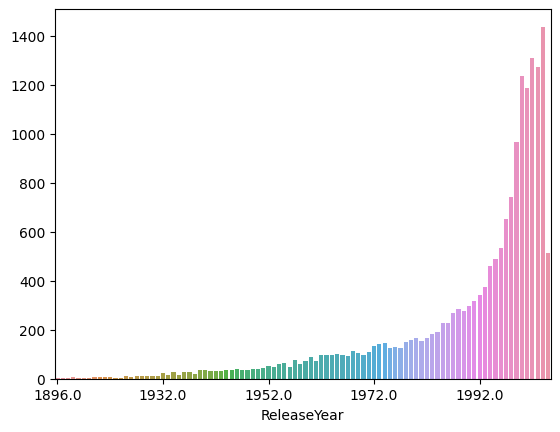

In [51]:
from matplotlib.ticker import MultipleLocator
# Number of movies per release year
n_movies_per_year = movies.groupby('ReleaseYear')['MovieId'].count()
sns.barplot(x=n_movies_per_year.index, y=n_movies_per_year.values)
plt.gca().xaxis.set_major_locator(MultipleLocator(20))

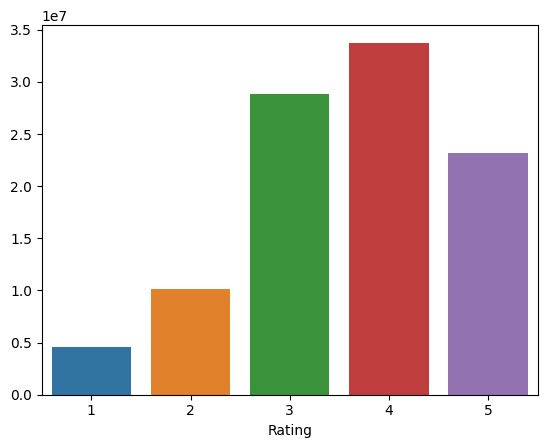

In [129]:
# Distribution of ratings
rating_counts = ratings.groupby('Rating')['CustId'].count()
sns.barplot(x=rating_counts.index, y=rating_counts.values);

In [110]:
# Frequency and rank of movie ratings (a.k.a. the illustration of Zipf's law)
n_ratings_per_movie = ratings.groupby('MovieId')['CustId'].count().sort_values(ascending=False).to_frame().rename({'CustId':'count'},axis=1)
n_ratings_per_movie['rank'] = n_ratings_per_movie['count'].rank(ascending=False, axis=0)

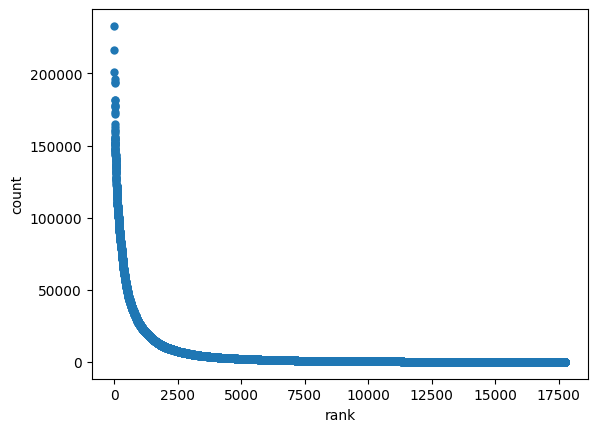

In [128]:
sns.scatterplot(data=n_ratings_per_movie, x='rank', y='count', linewidth=0);

From the plot above we can see, that relatively few movies attract the majority of the audience, while most of the remaining ones reside in the long tail of the curve.

In [139]:
# What are the worst-rated movies?
movies_mean_rating = ratings.groupby('MovieId')['Rating'].mean()
mean_ratings_20th_percentile = movies_mean_rating.quantile(.2)

print(f'Mean ratings 20th percentile: {mean_ratings_20th_percentile}')
print(f'Number of movies with mean rating below 20th percentile: {(movies_mean_rating <= mean_ratings_20th_percentile).sum()}')

Mean ratings 20th percentile: 2.801832405654062
Number of movies with mean rating below 20th percentile: 3554


<AxesSubplot: xlabel='ReleaseYear', ylabel='MeanRating'>

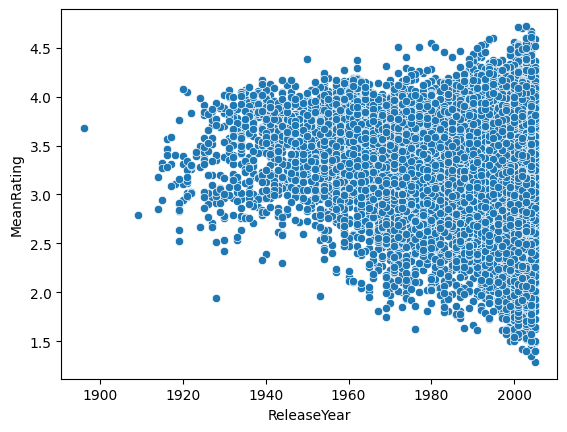

In [149]:
# How is the mean rating of a movie related to the release year
movie_year_mean_rating = pd.merge(movies.drop('MovieTitle', axis=1), movies_mean_rating, on='MovieId', how='inner').rename({'Rating':'MeanRating'},axis=1)
sns.scatterplot(movie_year_mean_rating,x='ReleaseYear',y='MeanRating')

As we move in time toward 2000's, the number of movies increases, but the spread of the mean ratings per movie increases as well. This means, that there are more movies, which people didn't really love. Most movies are average, some are good, some are even great, but the more movies we have, the greater the chance that some of them will be bad. Alternatively, we might argue that some of the movies are skewed towards bad ratings due to a small number of reviews, but we checked earlier, that this is probably not the case (there are only 6 movies, which were rated by less than 20 people). 

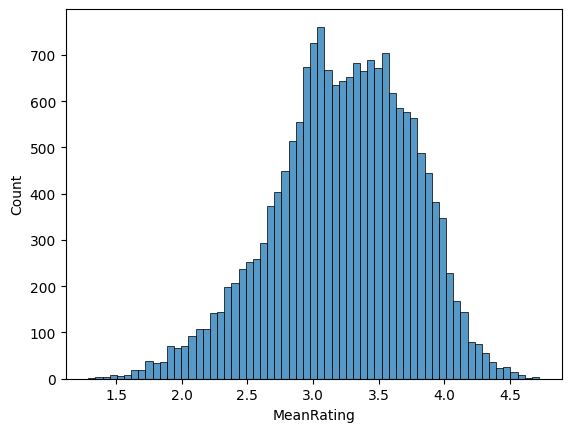

In [172]:
# How many movies are there with certain mean rating?
sns.histplot(movie_year_mean_rating['MeanRating']);

## Narrowing the data to a smaller subset

Contemporary real-world recommendation systems consist of 4 principal stages: Retrieval, Filtering, Scoring and Ordering. Retrieval stage focuses on narrowing down the subset of items relevant to a particular user and filtering ensures, that the candidates found earlier satisfy specific conditions, individual for every user (eg. age restrictions). Each candidate item is then scored with an appropriate model and ordered according to the score it received.

For more, see: https://medium.com/nvidia-merlin/recommender-systems-not-just-recommender-models-485c161c755e

With the data at hand, I'm relying only on explicit user ratings and the model I'm going to develop will be rather simple in its nature. I'm going to utilize Surprise package to build a model (matrix factorization approach) and then validate it with various metrics, like rmse, mse, hit rate, diversity, novelty etc. Due to the limited computational power of my PC (surprise does not support parallelization as far as I know), I was thinking of training the model on only a subset of available data. Later will utilize pySpark to train the model on the full dataset and compare the results.

Consciously throwing away the data doesn't seem to be a good idea (it's a loss of potentially valuable information) and it can generate certain problems with model's performance (prediction accuracy, user coverage, item diversity etc.). Nevertheless, for exercise purposes and reasons mentioned above, I'm going to exclude all movies with mean rating below 3.5.

In [214]:
movies_and_mean_ratings_merged = pd.merge(movies,movies_mean_rating,on='MovieId')
movies_subset_idx = movies_and_mean_ratings_merged[movies_and_mean_ratings_merged['Rating'] >= 3.5].index
ratings_subset = ratings[ratings['MovieId'].isin(movies_subset_idx)]
movies_subset = movies.iloc[movies_subset_idx]

In [218]:
ratings_subset.to_csv(data_dirpath + 'ratings_subset.csv')
movies_subset.to_csv(data_dirpath + 'movies_subset.csv')